### **Trader Behavior vs Market Sentiment Analysis**

This notebook analyzes how trader behavior (profitability, trade volume, risk) aligns or diverges from overall market sentiment (Fear–Greed Index).  
Using:  
1. . Bitcoin Market Sentiment Dataset
2. Historical Trader Data from Hyperliquid

I explored:  
- Profitability under different sentiment states  
- Buy vs Sell outcomes  
- Trade frequency behavior  
- Risk (PnL volatility, downside risk)  
- Predictive modeling (OLS + Random Forest)  
- Hidden patterns & strategy recommendations

1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


2.Load Datasets

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")


/tmp/ipython-input-957093046.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv("historical_data.csv")


In [4]:
sentiment.head()



,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


3.Data Cleaning & Preprocessing

3.1 Clean Sentiment Data

In [6]:
sentiment['timestamp'] = pd.to_numeric(sentiment['timestamp'], errors='coerce')
sentiment['sentiment_date'] = pd.to_datetime(sentiment['timestamp'], unit='s').dt.date
sentiment['classification'] = sentiment['classification'].astype(str).str.strip()


3.2 Clean Trades Data

In [7]:
# Convert Timestamp IST to datetime
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'],
                                         errors='coerce',
                                         format="%d-%m-%Y %H:%M")# Extract date
trades['trade_date'] = trades['Timestamp IST'].dt.date
# Convert PnL
trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
# Clean side
trades['Side'] = trades['Side'].astype(str).str.upper().str.strip()


In [9]:
sentiment.head()

,timestamp,value,classification,date,sentiment_date
0,1517463000,30,Fear,2018-02-01,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02,2018-02-02
2,1517635800,40,Fear,2018-02-03,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05,2018-02-05


In [11]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02


4.Merge Sentiment + Trades

In [12]:
merged = trades.merge(
    sentiment[['sentiment_date', 'classification', 'value']],
    left_on='trade_date',
    right_on='sentiment_date',
    how='left'
)


In [13]:
merged.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,sentiment_date,classification,value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed,80.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed,80.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed,80.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed,80.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,2024-12-02,Extreme Greed,80.0


5.Exploratory Data Analysis (EDA)

In [14]:
merged.groupby('classification')['Closed PnL'].mean()


,Closed PnL
classification,
Extreme Fear,190.099316
Extreme Greed,160.154764
Fear,144.129864
Greed,91.913789
Neutral,94.341828


In [15]:
merged.groupby(['classification', 'Side'])['Closed PnL'].mean()


classification  Side
Extreme Fear    BUY     265.802651
                SELL     82.382616
Extreme Greed   BUY      32.526054
                SELL    264.378509
Fear            BUY     219.511460
                SELL     59.007737
Greed           BUY      70.832767
                SELL    110.990948
Neutral         BUY      94.475896
                SELL     94.199137
Name: Closed PnL, dtype: float64

In [16]:
merged['classification'].value_counts()


,count
classification,
Greed,16373
Fear,12688
Neutral,10462
Extreme Greed,9708
Extreme Fear,1885


Average PnL by Sentiment

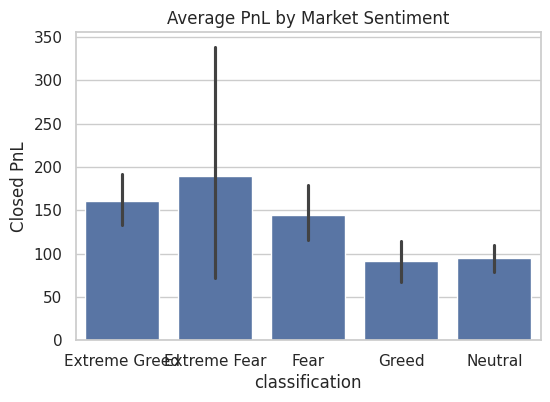

In [17]:
plt.figure(figsize=(6,4))
sns.barplot(data=merged, x='classification', y='Closed PnL')
plt.title("Average PnL by Market Sentiment")
plt.show()


Long vs Short Performance (BUY vs SELL)

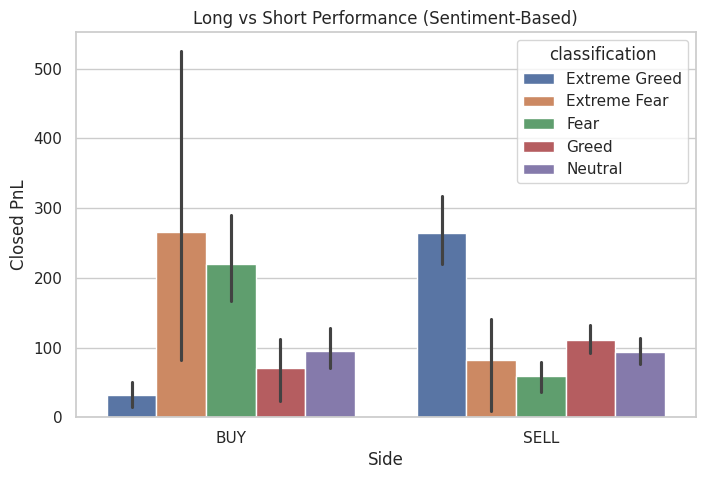

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='Side', y='Closed PnL', hue='classification')
plt.title("Long vs Short Performance (Sentiment-Based)")
plt.show()


Trade Frequency by Sentiment

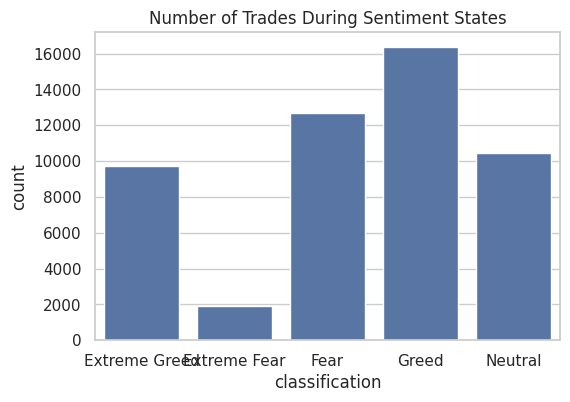

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(data=merged, x='classification')
plt.title("Number of Trades During Sentiment States")
plt.show()


6.Regression Model 1 (Sentiment value → PnL)

In [20]:
import statsmodels.api as sm
df = merged.dropna(subset=['Closed PnL', 'value'])
X = sm.add_constant(df['value'])
y = df['Closed PnL']
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             Closed PnL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3160
Date:                Wed, 19 Nov 2025   Prob (F-statistic):              0.574
Time:                        06:47:04   Log-Likelihood:            -4.4935e+05
No. Observations:               51116   AIC:                         8.987e+05
Df Residuals:                   51114   BIC:                         8.987e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.4430     23.306      5.769      0.0

Regression Line Plot

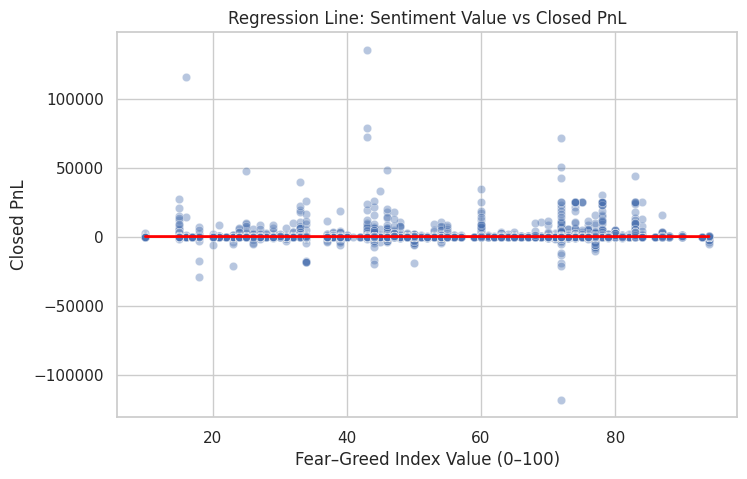

In [31]:
import matplotlib.pyplot as plt
import seaborn as sn
df_plot = df.copy()
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_plot['value'], y=df_plot['Closed PnL'], alpha=0.4)
# Regression line
sns.regplot(x=df_plot['value'], y=df_plot['Closed PnL'],
            scatter=False, color='red',
            line_kws={"linewidth":2})
plt.title("Regression Line: Sentiment Value vs Closed PnL")
plt.xlabel("Fear–Greed Index Value (0–100)")
plt.ylabel("Closed PnL")
plt.show()

7. Regression Model 2 (Sentiment category dummies)

Create dummies

In [32]:
df_clean2 = df_clean.copy()
if 'classification_nan' in df_clean2.columns:
    df_clean2 = df_clean2[df_clean2['classification_nan'] == 0]
    df_clean2 = df_clean2.drop(columns=['classification_nan'])


Fit OLS

In [33]:
import statsmodels.api as sm
feature_cols2 = [col for col in df_clean2.columns if col.startswith("classification_")]
X2 = df_clean2[feature_cols2]
X2 = sm.add_constant(X2)
y2 = df_clean2['Closed PnL']
model2 = sm.OLS(y2, X2).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:             Closed PnL   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.131
Date:                Wed, 19 Nov 2025   Prob (F-statistic):           0.000394
Time:                        06:55:38   Log-Likelihood:            -4.4934e+05
No. Observations:               51116   AIC:                         8.987e+05
Df Residuals:                   51111   BIC:                         8.987e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Model Diagnostics

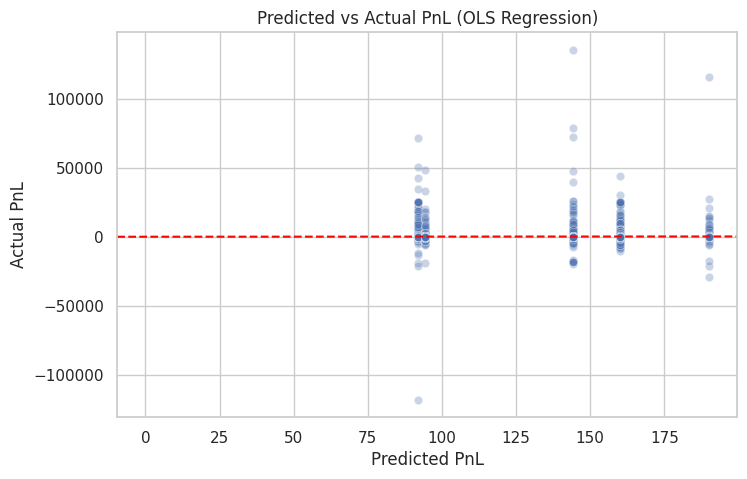

In [34]:
df_clean2['predicted'] = model2.predict(X2)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_clean2['predicted'], y=df_clean2['Closed PnL'], alpha=0.3)
plt.title("Predicted vs Actual PnL (OLS Regression)")
plt.xlabel("Predicted PnL")
plt.ylabel("Actual PnL")
plt.axline((0, 0), slope=1, color='red', linestyle='--')
plt.show()


Residual Plot

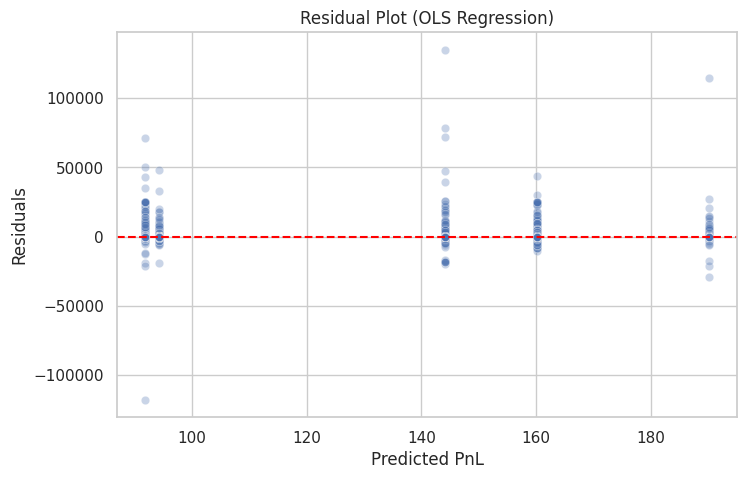

In [35]:
df_clean2['residuals'] = df_clean2['Closed PnL'] - df_clean2['predicted']
plt.figure(figsize=(8,5))
sns.scatterplot(x=df_clean2['predicted'], y=df_clean2['residuals'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (OLS Regression)")
plt.xlabel("Predicted PnL")
plt.ylabel("Residuals")
plt.show()



In [51]:
merged_clean = merged[merged['classification'] != "nan"].copy()


8. Risk Analysis (PnL Volatility)

In [52]:
risk_df_clean = merged_clean.groupby('classification')['Closed PnL'].agg(
    mean_return='mean',
    pnl_std='std',
    negative_pnl_percent=lambda x: (x < 0).mean(),
    worst_loss='min',
    best_win='max'
).reset_index()
display(risk_df_clean)


,classification,mean_return,pnl_std,negative_pnl_percent,worst_loss,best_win
0,Extreme_Fear,190.099316,3056.877390,0.106631,-29370.11980,115287.00000
1,Extreme_Greed,160.154764,1446.280470,0.049135,-10259.46800,44223.45187
2,Fear,144.129864,1889.694043,0.061081,-19841.24014,135329.09010
3,Greed,91.913789,1532.921493,0.073475,-117990.10410,71535.71674
4,Neutral,94.341828,852.518679,0.049799,-18993.46842,48504.09555


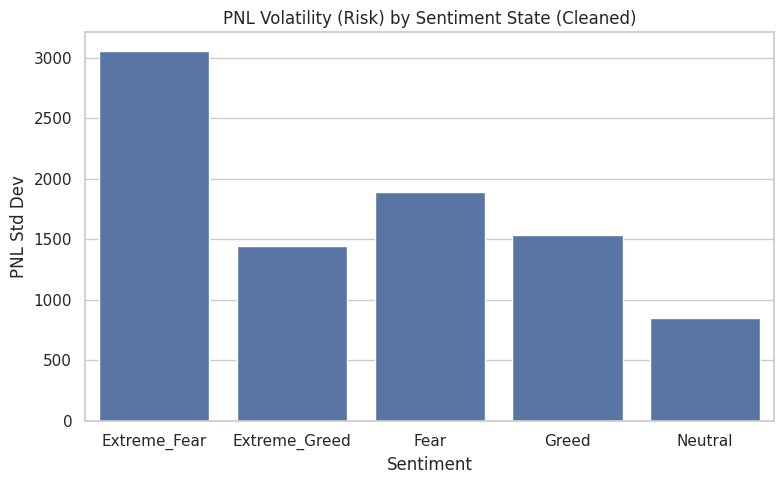

In [54]:
plt.figure(figsize=(8,5))
sns.barplot(data=risk_df_clean, x='classification', y='pnl_std')
plt.title("PNL Volatility (Risk) by Sentiment State (Cleaned)")
plt.xlabel("Sentiment")
plt.ylabel("PNL Std Dev")
plt.tight_layout()
plt.show()


9.Random Forest – Nonlinear Analysis

Since PnL is highly non-linear, I added a Random Forest model to evaluate non-linear feature importance. This helps validate whether sentiment categories influence PnL in ways that linear regression cannot capture.

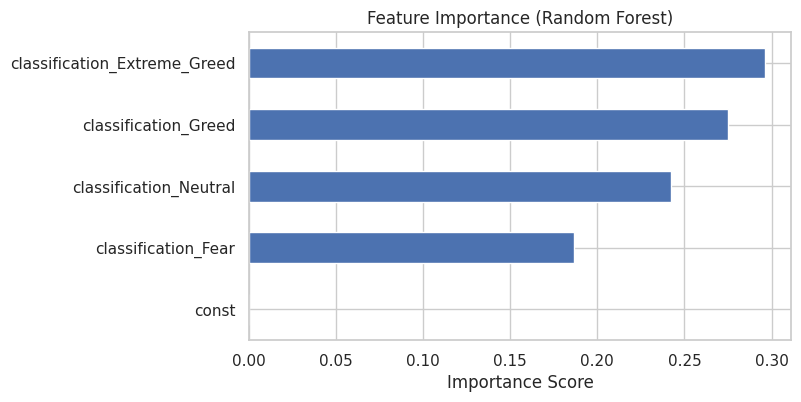

In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X2, y2)
importances = pd.Series(rf.feature_importances_, index=X2.columns)
plt.figure(figsize=(7,4))
importances.sort_values().plot(kind='barh')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.show()
